In [105]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pathlib import Path

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example
from tensorflow.train import FeatureList, FeatureLists, SequenceExample
import tensorflow_hub as hub

import time

In [106]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
[print(item) for item in dataset]

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


[None, None, None, None, None, None, None, None, None, None]

In [3]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}

dataset = tf.data.Dataset.from_tensor_slices(X_nested)
[print(item) for item in dataset]

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


2025-03-24 20:35:19.152241: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[None, None, None]

In [4]:
# chaining Tansformation

dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)  # we can do drop remainder = True

In [5]:
for i in dataset:
    print(i)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [6]:
dataset = dataset.map(
    lambda x: x * 2
)  # we can spawn multiple threads to speed things up by setting num_parallel_calls to number of therads
[print(item) for item in dataset]

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


2025-03-24 20:35:19.219890: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[None, None, None, None, None]

In [7]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) < 50)
[print(item) for item in dataset]

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


[None, None]

In [8]:
[print(item) for item in dataset.take(2)]  # taking only a sample

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


[None, None]

In [9]:
# shuffling data
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
[print(item) for item in dataset]

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


[None, None, None]

In [10]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42
)

In [11]:
def save_to_csv_files(data, name_prefix, header=None, n_parts=10):

    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(exist_ok=True, parents=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(part_csv.as_posix())

        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths


train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [12]:
filepath_datasets = tf.data.Dataset.list_files(train_filepaths, seed=42)
# for filepath in filepath_datasets:
#     print(filepath)

n_readers = 5
dataset = filepath_datasets.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers,
    num_parallel_calls=2,
)

In [13]:
# Preprocessing data

scaler = StandardScaler()
scaler.fit(X_train)

X_mean, X_std = scaler.mean_, scaler.scale_
n_inputs = 8  # number of columns


def parse_csv_line(line):
    defs = [0.0] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])


def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y


# Putting everything together + prefetching
def csv_reader_dataset(
    filepaths,
    n_readers=5,
    n_read_threads=None,
    n_parse_threads=5,
    shuffle_buffer_size=10_000,
    seed=42,
    batch_size=32,
):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers,
        num_parallel_calls=n_read_threads,
    )
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size=batch_size).prefetch(1), dataset

In [14]:
example_set = csv_reader_dataset(train_filepaths, batch_size=3)

In [15]:
# Using the dataset with keras

train_set, dtrain = csv_reader_dataset(train_filepaths)
valid_set, dvalid = csv_reader_dataset(valid_filepaths)
test_set, dtest = csv_reader_dataset(test_filepaths)

tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(42)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=X_train.shape[1:]),
        tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - loss: 1.2842 - val_loss: 692.2764
Epoch 2/5


2025-03-24 20:35:20.105846: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/chiragbangera/Developer/Handsonml/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 2.4813 - val_loss: 5.6114
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.5948 - val_loss: 140.3738
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.5466 - val_loss: 0.5109
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.4969 - val_loss: 1.3730


2025-03-24 20:35:21.890809: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")

        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 5/5

In [17]:
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 5/5

In [18]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


2025-03-24 20:35:30.988300: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


In [19]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [20]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"], compression_type="GZIP")

for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


In [21]:
person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"])),
        }
    )
)

with tf.io.TFRecordWriter("my_contracts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

In [22]:
# loading and parsing examples

feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}


def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)


dataset = tf.data.TFRecordDataset(["my_contracts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tenso

In [23]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [24]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [25]:
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)


dataset = tf.data.TFRecordDataset(["my_contracts.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
    print(parsed_examples)  # two examples at a time

{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Ten

In [26]:
# dummy protobuffs
def serialize_example(feature, label):
    feature_dict = {
        "feature": tf.train.Feature(float_list=FloatList(value=feature)),
        "label": tf.train.Feature(int64_list=Int64List(value=[label])),
    }

    example = Example(features=Features(feature=feature_dict))

    return example.SerializeToString()


# dummy dataset (2 sample and 3 features each)
features = [[1.2, 3.4, 5.6], [7.8, 9.0, 2.3]]
labels = [0, 1]

# write to a TFrecord file
tfrecord_file = "practice1.tfrecord"
with tf.io.TFRecordWriter(tfrecord_file) as f:
    for feature, label in zip(features, labels):
        serialized_example = serialize_example(feature=feature, label=label)
        f.write(serialized_example)

In [27]:
# Reading & Decoding a TFRecord File

feature_description = {
    "feature": tf.io.FixedLenFeature([3], tf.float32),
    "label": tf.io.FixedLenFeature([], tf.int64),
}


# parsiing function
def parse_tfrecord(example_proto):
    return tf.io.parse_example(example_proto, feature_description)


# reading TFRecord dataset
raw_dataset = tf.data.TFRecordDataset([tfrecord_file])
parsed_dataset = raw_dataset.map(parse_tfrecord)

for record in parsed_dataset:
    print(record)

{'feature': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.2, 3.4, 5.6], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>}
{'feature': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([7.8, 9. , 2.3], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>}


In [28]:
print(np.array(features).shape)
print(tf.stack(features))

(2, 3)
tf.Tensor(
[[1.2 3.4 5.6]
 [7.8 9.  2.3]], shape=(2, 3), dtype=float32)


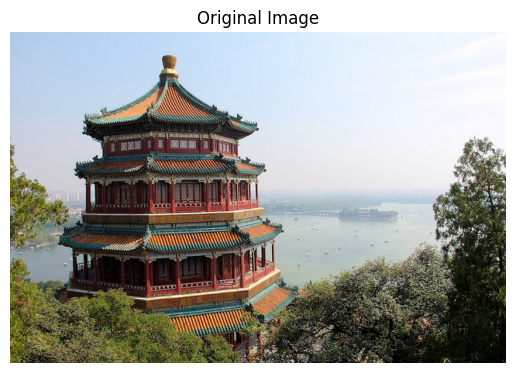

In [29]:
# storing images and tensors in TFRecords

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [30]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(
    features=Features(
        feature={"image": Feature(bytes_list=BytesList(value=[data.numpy()]))}
    )
)
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("my_image.tfrecord") as f:
    f.write(serialized_example)

In [31]:
# reading image
feature_description = {"image": tf.io.VarLenFeature(tf.string)}


def parse(serialize_example):
    example_with_image = tf.io.parse_single_example(
        serialized_example, feature_description
    )

    # return tf.io.decode_jpeg(example_with_image['image'].values[0])
    return tf.io.decode_image(example_with_image["image"].values[0])


dataset = tf.data.TFRecordDataset("my_image.tfrecord").map(parse)

In [32]:
# Handling Lists of Lists using the SequenceExample probuf

context = Features(
    feature={
        "author_id": Feature(int64_list=Int64List(value=[123])),
        "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
        "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25])),
    }
)

content = [
    ["When", "shall", "we", "three", "meet", "again", "?"],
    ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"],
]
comments = [
    ["When", "the", "hurlyburly", "'s", "done", "."],
    ["When", "the", "battle", "'s", "lost", "and", "won", "."],
]


def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8") for word in words]))


content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]


sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(
        feature_list={
            "content": FeatureList(feature=content_features),
            "comments": FeatureList(feature=comments_features),
        }
    ),
)

serialized_sequence_example = sequence_example.SerializeToString()

In [33]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}

sequence_feature_description = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example,
    context_feature_descriptions,
    sequence_feature_description,
)

parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])
print(parsed_content)

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


In [34]:
# Normalization Layer

tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.Sequential([norm_layer, tf.keras.layers.Dense(1)])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train)
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 3.7313 - val_loss: 1.6242
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.7741 - val_loss: 0.6081
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 0.6162 - val_loss: 0.6522
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.5949 - val_loss: 0.6388
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.5856 - val_loss: 0.6315


In [35]:
# standalone normalization

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [36]:
tf.random.set_seed(42)
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid))

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 3.7557 - val_loss: 1.8639


In [37]:
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]
y_pred = final_model.predict(X_new)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[0.77830833]
 [1.0422463 ]
 [1.9474719 ]]


In [38]:
# applying normlayer using map()

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)
dataset = dataset.map(lambda X, y: (norm_layer(X), y))
list(dataset.take(1))

[(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
  array([[-0.19397889, -1.0778131 , -0.9433854 ,  0.01485314,  0.02073333,
          -0.57291627,  0.9292612 , -1.4221537 ],
         [ 0.7519831 , -1.868895  ,  0.40547806, -0.23327684,  1.8614649 ,
           0.20516537, -0.9165477 ,  1.0966716 ],
         [-0.41469118,  0.02970133,  0.8180882 ,  1.0567837 , -0.0878671 ,
          -0.2998328 ,  1.3087282 , -1.697027  ],
         [ 1.7188957 , -1.3151377 ,  0.32664376, -0.2195511 , -0.33792186,
          -0.11146631, -0.9821345 ,  0.94174504],
         [-0.9620722 , -1.2360295 , -0.05625783, -0.03124396,  1.7090592 ,
          -0.30256987, -0.80411196,  1.3265638 ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
  array([[1.442],
         [1.687],
         [1.621],
         [2.621],
         [0.956]])>)]

In [39]:
class MyNormalization(tf.keras.layers.Layer):
    def adapt(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.std_ = np.std(X, axis=0, keepdims=0)

    def call(self, inputs):
        eps = tf.keras.backend.epsilon()  # small smoothing term
        return (inputs - self.mean_) / (self.std_ + eps)


my_norm_layer = MyNormalization()
my_norm_layer.adapt(X_train)
X_train_scaled = my_norm_layer(X_train)

In [40]:
# discretization layer

age = tf.constant([[10.0], [93.0], [57.0], [18.0], [37.0], [5.0]])
discretization_layer = tf.keras.layers.Discretization(bin_boundaries=[18.0, 50])
age_categories = discretization_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]])>

In [47]:
# The categoryEncoding layer
# category encoding is used when there are a less than few dozen or two categories (one hot encoding)
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)>

In [48]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

In [ ]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3])

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [ ]:
# categorical text features
# string lookup layers

cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=int64, numpy=
array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])>

In [55]:
tf.keras.layers.Flatten()(tf.one_hot(two_age_categories, depth=3))

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [62]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]])>

In [64]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]])>

In [ ]:
# embedding layer: Categories
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(
    input_dim=5, output_dim=2
)  # embedding with 5 rows and 2D embeddings
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.04175374, 0.03964336],
       [0.00654628, 0.00557454],
       [0.04175374, 0.03964336]], dtype=float32)>

In [ ]:
tf.random.set_seed(42)
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=[], dtype=tf.string),
        str_lookup_layer,
        tf.keras.layers.Embedding(
            input_dim=str_lookup_layer.vocabulary_size(), output_dim=2
        ),
    ]
)
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.00653458, -0.04627232],
       [-0.01059072, -0.02566924],
       [ 0.00653458, -0.04627232]], dtype=float32)>

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000).astype(object)
y_train = np.random.rand(10_000, 1)
X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000).astype(object)
y_valid = np.random.rand(2_000, 1)

num_inputs = tf.keras.layers.Input(shape=[8], name="num")
cat_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="cat")
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(X_train_cat)
lookup_embed_layer = tf.keras.Sequential(
    [
        cat_inputs,
        str_lookup_layer,
        tf.keras.layers.Embedding(
            input_dim=str_lookup_layer.vocabulary_size(), output_dim=2
        ),
        tf.keras.layers.Flatten(),
    ]
)
embedded_layer = lookup_embed_layer(cat_inputs)
embedded_input = tf.keras.layers.concatenate([num_inputs, embedded_layer])
outputs = tf.keras.layers.Dense(1)(embedded_input)
model = tf.keras.models.Model(inputs=[num_inputs, cat_inputs], outputs=[outputs])
model.compile(loss="mse", optimizer="sgd")
history = model.fit(
    (X_train_num, X_train_cat),
    y_train,
    validation_data=((X_valid_num, X_valid_cat), y_valid),
    epochs=5,
)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.1912 - val_loss: 0.1152
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.1023 - val_loss: 0.0962
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.0895 - val_loss: 0.0888
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 0.0849 - val_loss: 0.0857
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.0831 - val_loss: 0.0844


In [96]:
train_set = tf.data.Dataset.from_tensor_slices(
    ((X_train_num, X_train_cat), y_train)
).batch(32)

valid_set = tf.data.Dataset.from_tensor_slices(
    ((X_valid_num, X_valid_cat), y_valid)
).batch(32)
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.0830 - val_loss: 0.0834
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 0.0829 - val_loss: 0.0832
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 0.0828 - val_loss: 0.0831
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 0.0827 - val_loss: 0.0830
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 0.0827 - val_loss: 0.0830


In [ ]:
train_data = ["to be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = (
    tf.keras.layers.TextVectorization()
)  # We can also do ragged tensor true it will remove the trailin 0s
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]])>

In [ ]:
text_vec_layer = tf.keras.layers.TextVectorization(
    output_mode="tf_idf"
)  # term frequency x inverse-document-frequency
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

In [107]:
# using pretrained language model components

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")
sentence_embeddings = hub_layer(tf.constant(["To be", "Not to be"]))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

In [ ]:
# Tensorflow datasets